# Employee Attrition & Performance Project

**Contents**

This notebook implements the full project described:
- Phase 1: Data collection, preprocessing, and EDA
- Phase 2: Predictive modeling (classification & regression)
- Phase 3: Deep learning (Keras/TensorFlow)
- Phase 4: Reporting and visualizations





---


## Phase 1 — Data Collection & Exploratory Data Analysis (EDA)

**Step 1 — Load dataset and basic preprocessing**

The following code will:
- Load the CSV
- Clean column names, drop duplicates
- Coerce numeric columns and fill missing values
- Create an `Attrition_flag` column (0/1)


In [1]:
\
# Phase 1: Load and preprocess
import pandas as pd, numpy as np
from scipy import stats

DATA_PATH = "Employe_Performance_dataset.csv"
df = pd.read_csv(DATA_PATH)
print("Original shape:", df.shape)
df.columns = [c.strip() for c in df.columns]

# Common renames (adjust if your file uses different names)
col_map = {}
aliases = {
    "Employee ID": ["EmployeeID","EmpID","ID","Emp Id"],
    "Name": ["Employee Name","FullName"],
    "Age": ["age","Age"],
    "Department": ["Dept","department"],
    "Salary": ["salary","Salary"],
    "Years at Company": ["YearsAtCompany","Years at Company"],
    "Performance Score": ["Performance","Performance Score","Perf_Score","PerformanceScore"],
    "Attrition": ["Attrition","Left","Exited","Resigned","Status"]
}
for target, variants in aliases.items():
    for v in variants:
        if v in df.columns and target not in df.columns:
            col_map[v] = target
df = df.rename(columns=col_map)
print("Columns after rename:", df.columns.tolist())

# Drop exact duplicates
df = df.drop_duplicates().reset_index(drop=True)
print("Shape after dropping duplicates:", df.shape)

# Coerce numeric-like columns
for col in ["Salary","Performance Score","Age","Years at Company"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(",","").str.strip(), errors="coerce")

# Create Attrition_flag (binary)
if "Attrition" in df.columns:
    df["Attrition_flag"] = df["Attrition"].astype(str).str.lower().map(lambda x: 1 if x in ["yes","y","true","1","leave","left","resigned","exited"] else 0)
else:
    df["Attrition_flag"] = 0

# Fill missing values: numeric -> median, categorical -> mode
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols]
for c in num_cols:
    df[c] = df[c].fillna(df[c].median())
for c in cat_cols:
    if df[c].isnull().any():
        df[c] = df[c].fillna(df[c].mode().iat[0] if not df[c].mode().empty else "Unknown")

print("Final shape after filling NAs:", df.shape)
df.head(5)


Original shape: (1000, 12)
Columns after rename: ['Employee ID', 'Name', 'Age', 'Gender', 'Department', 'Salary', 'Joining Date', 'Performance Score', 'Experience', 'Attrition', 'Location', 'Session']
Shape after dropping duplicates: (1000, 12)
Final shape after filling NAs: (1000, 13)


,Employee ID,Name,Age,Gender,Department,Salary,Joining Date,Performance Score,Experience,Attrition,Location,Session,Attrition_flag
0,1,Cory Escobar,48,Female,HR,5641,2015-05-03,2.0,16,Active,New York,Night,0
1,2,Timothy Sanchez,25,Other,Sales,4249,2020-11-09,2.0,11,Inactive,Los Angeles,Evening,0
2,3,Chad Nichols,57,Other,Sales,3058,2019-02-12,3.0,1,Inactive,New York,Morning,0
3,4,Christine Williams,58,Female,IT,5895,2017-09-08,2.0,13,Inactive,Los Angeles,Evening,0
4,5,Amber Harris,35,Other,IT,4317,2020-02-15,5.0,16,Inactive,New York,Evening,0


**Step 2 — Exploratory Data Analysis (EDA)**

Tasks:
- Descriptive statistics
- Pairplot (Seaborn) / Scatter matrix
- Heatmap (correlations)
- Outlier detection (boxplots / IQR)


,feature,mean,median,var,std,mode
0,Employee ID,500.500,500.5,8.341667e+04,288.819436,1.0
1,Age,40.782,40.0,1.995120e+02,14.124871,20.0
2,Salary,5917.374,5889.0,5.287323e+06,2299.418003,2364.0
3,Performance Score,2.955,3.0,1.019995e+00,1.009948,3.0
4,Experience,10.120,10.0,3.264625e+01,5.713689,7.0
5,Attrition_flag,0.000,0.0,0.000000e+00,0.000000,0.0


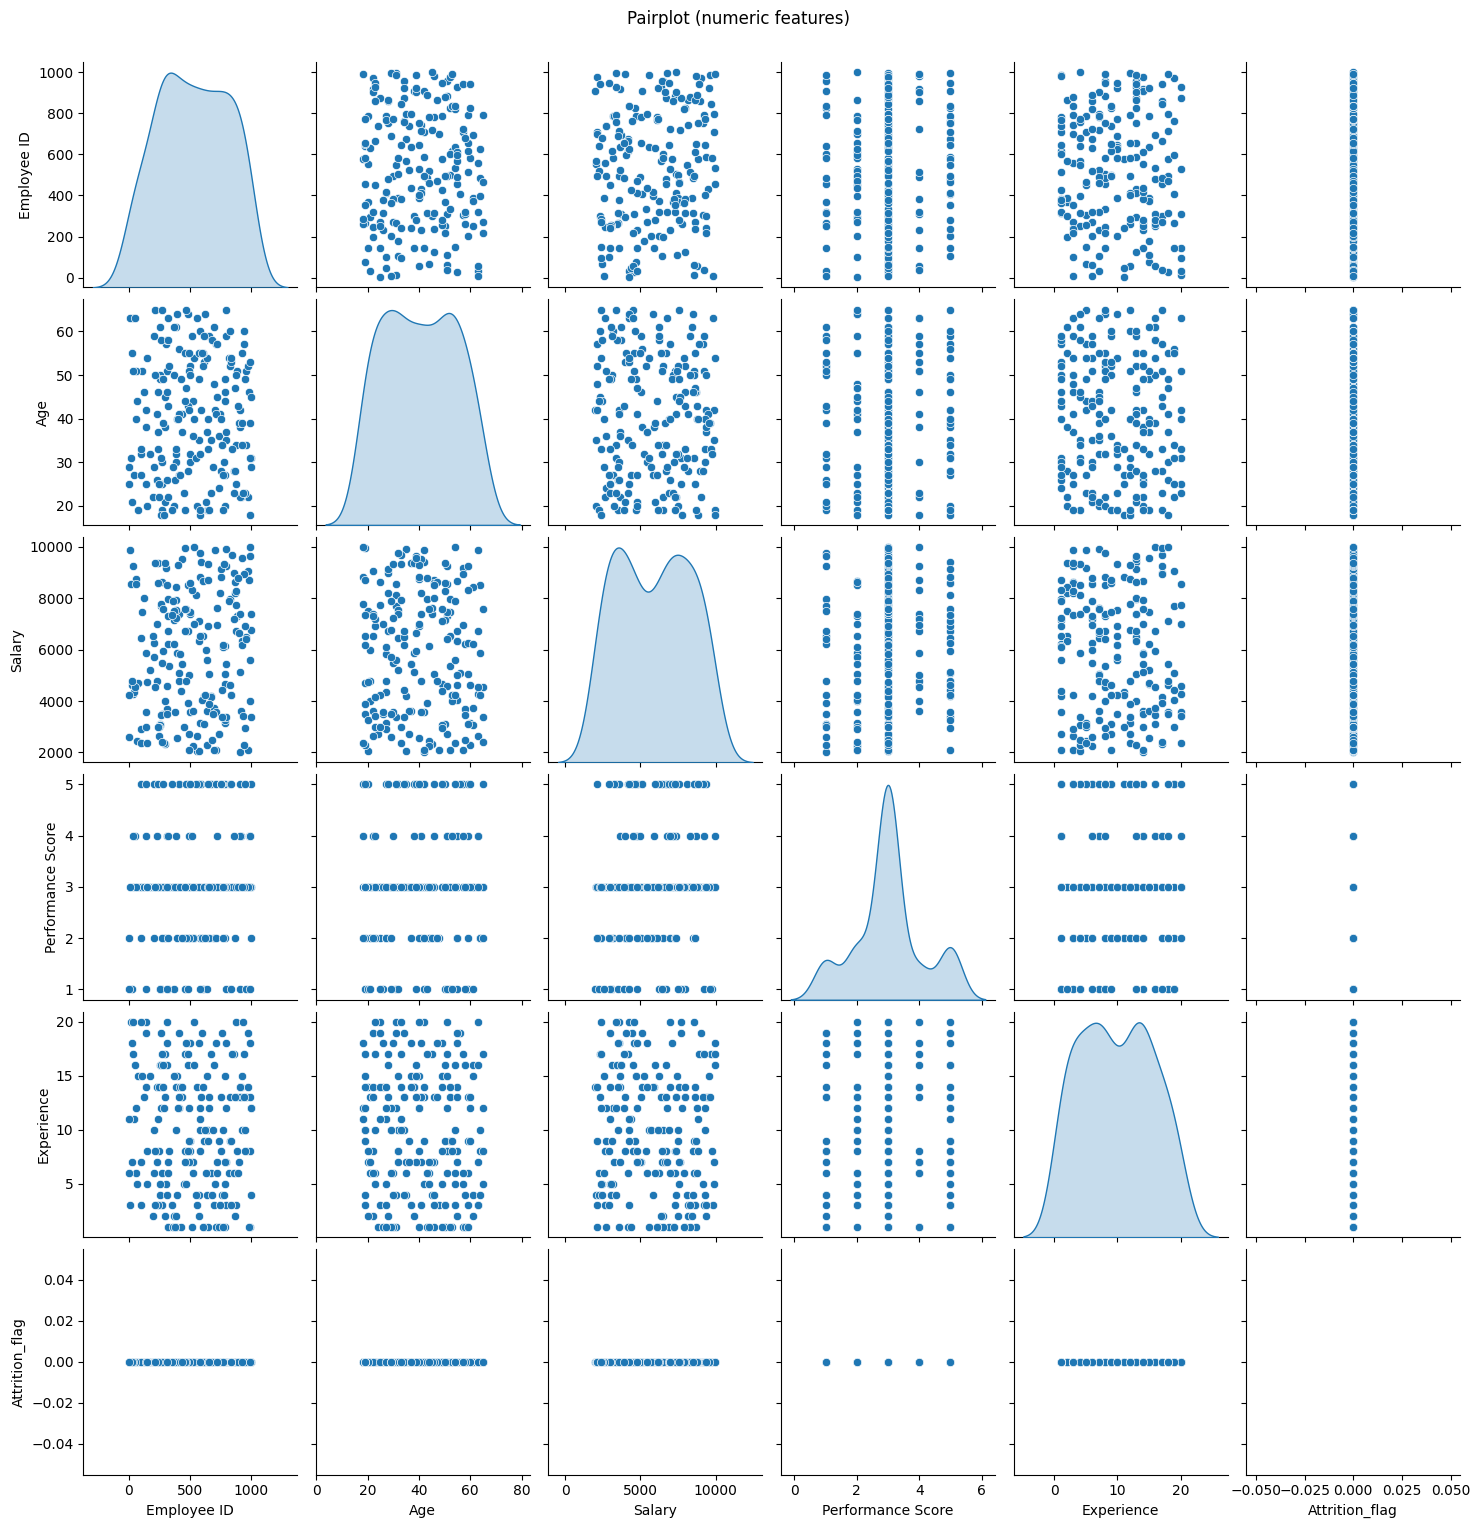

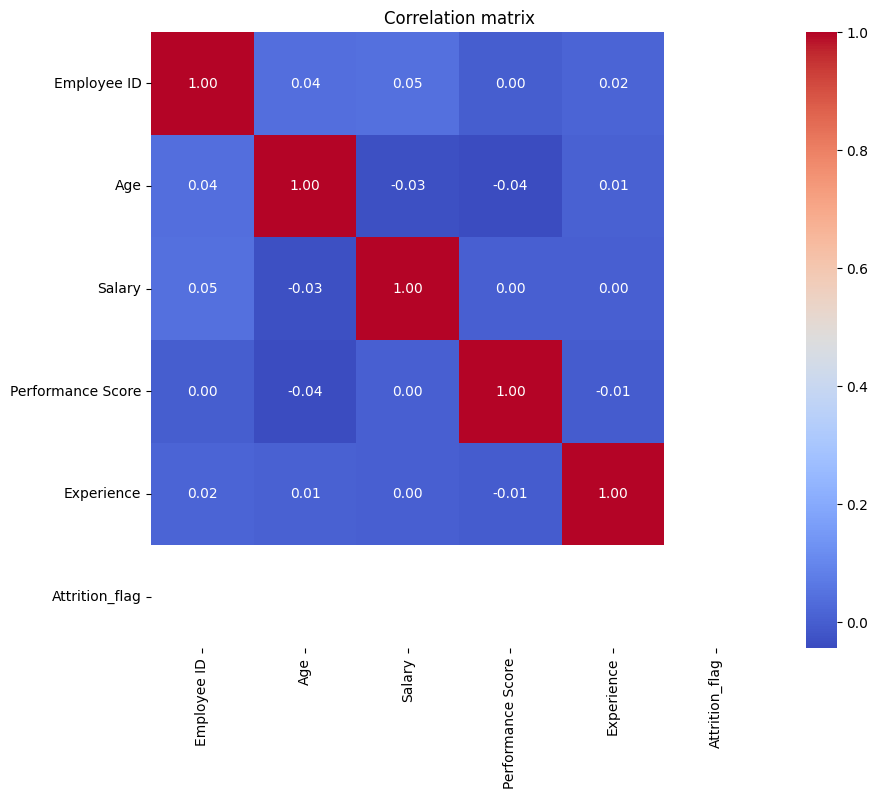

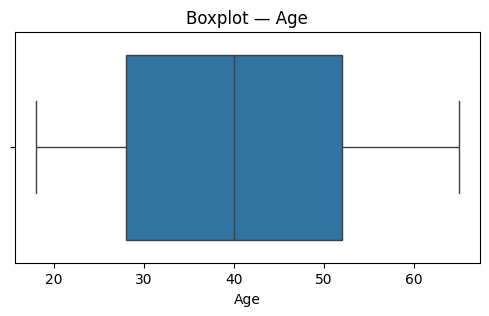

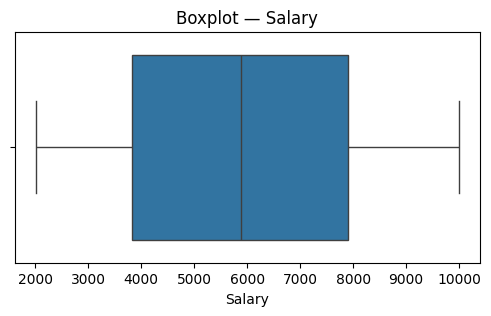

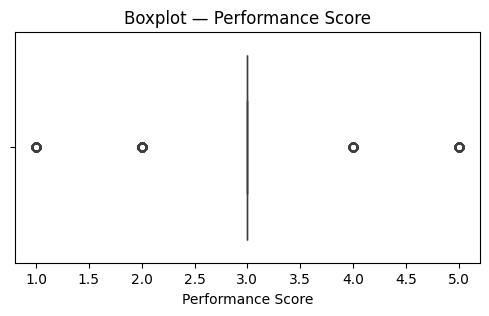

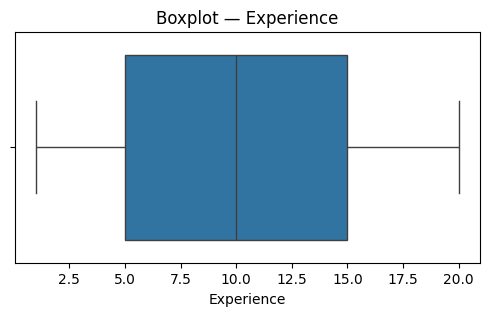

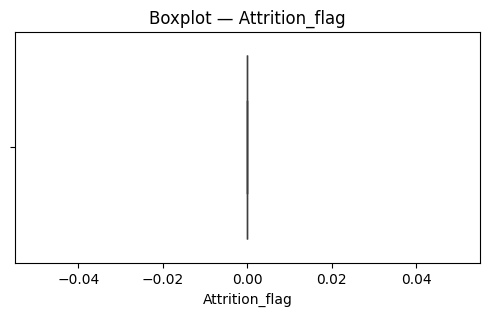

In [2]:
\
# EDA: descriptive stats and visualizations
import matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline

# Descriptive statistics for numeric columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
desc = df[num_cols].agg(['mean','median','var','std']).transpose().reset_index().rename(columns={'index':'feature'})
modes = {c: (df[c].mode().iat[0] if not df[c].mode().empty else None) for c in num_cols}
desc['mode'] = desc['feature'].map(modes)
display(desc)

# Pairplot (sample if large)
sample = df.sample(min(len(df), 200), random_state=0)
sns.pairplot(sample[num_cols], diag_kind='kde', corner=False)
plt.suptitle('Pairplot (numeric features)', y=1.02)
plt.show()

# Correlation heatmap
corr = df[num_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation matrix")
plt.show()

# Boxplots to identify outliers
for c in [c for c in num_cols if c not in ['Employee ID']][:6]:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=df[c])
    plt.title(f"Boxplot — {c}")
    plt.show()


**Step 3 — Probability & Statistical Analysis**

Tasks:
- Probability of leaving by department/performance
- Bayes' Theorem: P(Attrition | Low Performance)
- Hypothesis testing: ANOVA to test if mean performance differs across departments


In [4]:
\
# Probability analysis and hypothesis testing
# 1) Probability of leaving overall and by department
# let qcut create its own categories (no labels required)
perf_q = pd.qcut(df['Performance Score'], q=4, duplicates='drop')
df['Perf_bin'] = perf_q
perf_probs = df.groupby('Perf_bin')['Attrition_flag'].agg(['mean','count']).rename(columns={'mean':'attrition_rate'})
display(perf_probs)

# If you still want simple labels like Q1..Qk, map them to the categories found:
categories = perf_q.cat.categories
label_map = {cat: f"Q{i+1}" for i,cat in enumerate(categories)}
df['Perf_bin_label'] = df['Perf_bin'].map(label_map)
display(df['Perf_bin_label'].value_counts().sort_index())



C:\Users\hp\AppData\Local\Temp\ipykernel_12992\2030660898.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  perf_probs = df.groupby('Perf_bin')['Attrition_flag'].agg(['mean','count']).rename(columns={'mean':'attrition_rate'})


,attrition_rate,count
Perf_bin,,
"(0.999, 3.0]",0.0,813
"(3.0, 5.0]",0.0,187


Perf_bin_label
Q1    813
Q2    187
Name: count, dtype: int64

## Phase 2 — Predictive Modeling

Step 4: Feature engineering & encoding
Step 5: Attrition prediction (classification)
Step 6: Performance prediction (regression)


In [6]:
\
# Phase 2: Feature engineering and classic ML models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

# Diagnostic: check target distribution and basic dataset sanity
print("Attrition_flag value counts:")
print(df_model['Attrition_flag'].value_counts(dropna=False))

# Show department & attrition crosstab (if Department exists)
if 'Department' in df_model.columns:
    print("\nAttrition by Department (counts):")
    print(pd.crosstab(df_model['Department'], df_model['Attrition_flag']))

# Show perf bin counts (if present)
if 'Perf_bin' in df_model.columns:
    print("\nPerf_bin distribution:")
    print(df_model['Perf_bin'].value_counts())


Attrition_flag value counts:
Attrition_flag
0    1000
Name: count, dtype: int64

Attrition by Department (counts):
Attrition_flag    0
Department         
HR              323
IT              339
Sales           338

Perf_bin distribution:
Perf_bin
(0.999, 3.0]    813
(3.0, 5.0]      187
Name: count, dtype: int64


## Phase 3 — Deep Learning Models (Keras/TensorFlow)

Step 7: Neural network for regression (performance)
Step 8: Neural network for classification (attrition)

> If TensorFlow isn't available, fallback to sklearn MLPs is provided in the code.


In [7]:
\
# Phase 3: Deep learning (try to use Keras, otherwise sklearn MLP)
import numpy as np
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    tf_available = True
except Exception as e:
    print("TensorFlow not available — will fallback to sklearn MLP. Error:", e)
    tf_available = False

# Prepare data for DL: use earlier X, y (scaled)
if tf_available:
    # Regression NN for Performance Score (if available)
    if 'Performance Score' in df.columns:
        X_reg = X.copy()
        if 'Performance Score' in X_reg.columns:
            X_reg = X_reg.drop(columns=['Performance Score'])
        y_reg = df['Performance Score'].values
        from sklearn.model_selection import train_test_split
        Xtr, Xte, ytr, yte = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)
        model = keras.Sequential([
            layers.Input(shape=(Xtr.shape[1],)),
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(1, activation='linear')
        ])
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        history = model.fit(Xtr, ytr, validation_data=(Xte,yte), epochs=30, batch_size=16, verbose=1)
        # evaluate
        print("Regression NN evaluation:", model.evaluate(Xte,yte))
    # Classification NN for Attrition
    if 'Attrition_flag' in df.columns:
        y_cls = df['Attrition_flag'].values
        Xcls = X.copy()
        Xtr, Xte, ytr, yte = train_test_split(Xcls, y_cls, test_size=0.2, random_state=42, stratify=y_cls)
        modelc = keras.Sequential([
            layers.Input(shape=(Xtr.shape[1],)),
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ])
        modelc.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        historyc = modelc.fit(Xtr, ytr, validation_data=(Xte,yte), epochs=30, batch_size=16, verbose=1)
        # predictions and metrics
        preds = (modelc.predict(Xte) > 0.5).astype(int).ravel()
        from sklearn.metrics import classification_report
        print(classification_report(yte, preds))
else:
    # Fallback to sklearn MLPs
    from sklearn.neural_network import MLPClassifier, MLPRegressor
    if 'Attrition_flag' in df.columns:
        mlpc = MLPClassifier(hidden_layer_sizes=(64,32), max_iter=300, random_state=42)
        mlpc.fit(X_train, y_train)
        print("MLP Classifier report:")
        print(classification_report(y_test, mlpc.predict(X_test)))
    if 'Performance Score' in df.columns:
        mlpr = MLPRegressor(hidden_layer_sizes=(64,32), max_iter=300, random_state=42)
        mlpr.fit(Xr_train, yr_train)
        yr_pred_mlp = mlpr.predict(Xr_test)
        print("MLP Regressor R2:", r2_score(yr_test, yr_pred_mlp))


Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 3.0639 - mae: 1.4462 - val_loss: 1.0308 - val_mae: 0.8084
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7293 - mae: 0.6644 - val_loss: 0.6190 - val_mae: 0.6191
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5821 - mae: 0.6086 - val_loss: 0.5998 - val_mae: 0.6219
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5550 - mae: 0.5928 - val_loss: 0.5920 - val_mae: 0.6071
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5340 - mae: 0.5808 - val_loss: 0.5766 - val_mae: 0.6190
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5188 - mae: 0.5818 - val_loss: 0.6054 - val_mae: 0.5938
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5112 - mae: 0.5702 - val_loss: 0.5705 - val_mae: 0.5972
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5036 - mae: 0.5668 - val_loss: 0.5658 - val_mae: 0.6023
Epoch 9/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4912 - mae:

## Phase 4 — Reporting, Insights & Export

Step 9: Summarize insights and recommendations
Step 10: Save visualizations and export results


In [3]:
# Phase 4: Summaries & saving outputs (robust fixed version)
import os
# conditionally import pandas to avoid unnecessary re-import
if 'pd' not in globals():
    import pandas as pd

# Use existing OUT_DIR if present; otherwise set a default
if 'OUT_DIR' not in globals():
    OUT_DIR = "/mnt/data/project_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# Preserve saved_files if provided by the notebook already
if 'saved_files' not in globals():
    saved_files = []

# --- Ensure `df` exists (compute / load if missing) ---
if 'df' not in globals():
    # Attempt to load df from known DATA_PATH or common filenames if possible
    loaded = False
    possible_paths = []
    if 'DATA_PATH' in globals():
        possible_paths.append(DATA_PATH)
    # Common fallback filenames (small set)
    possible_paths.extend([
        "Employe_Performance_dataset.csv",
        "Employee_Performance_dataset.csv",
        "data/Employe_Performance_dataset.csv",
        "data/Employee_Performance_dataset.csv",
    ])
    for path in possible_paths:
        try:
            if path and os.path.exists(path):
                df = pd.read_csv(path)
                # basic cleanup consistent with earlier preprocessing
                df.columns = [c.strip() for c in df.columns]
                loaded = True
                print(f"Loaded dataset into 'df' from: {path}")
                break
        except Exception:
            # try next path
            continue
    if not loaded:
        raise NameError("DataFrame 'df' not found in the notebook globals and could not be loaded from known paths. "
                        "Please run earlier cells that create 'df' or set DATA_PATH to a valid CSV file path.")

# --- Ensure `desc` exists (compute if missing) ---
if 'desc' not in globals():
    # compute basic descriptive stats for numeric columns
    num_cols = df.select_dtypes(include=['number']).columns.tolist()
    if len(num_cols) > 0:
        desc = df[num_cols].agg(['mean', 'median', 'var', 'std']).transpose().reset_index().rename(columns={'index': 'feature'})
    else:
        desc = pd.DataFrame(columns=['feature', 'mean', 'median', 'var', 'std'])

# Save descriptive stats (if non-empty)
desc_path = os.path.join(OUT_DIR, "descriptive_stats.csv")
desc.to_csv(desc_path, index=False)
saved_files.append(desc_path)

# --- Ensure dept_probs exists (compute if missing and Department column exists) ---
dept_csv_path = None

# If Attrition_flag isn't present, try to infer it from 'Status' if available.
# We interpret 'Inactive' as attrition (1) and 'Active' as not attrition (0).
if 'Attrition_flag' not in df.columns and 'Status' in df.columns:
    df['Attrition_flag'] = df['Status'].astype(str).str.strip().str.lower().map({'inactive': 1, 'active': 0}).fillna(0).astype(int)

# If Attrition_flag still doesn't exist, we won't attempt to compute department attrition rates.
if 'dept_probs' not in globals():
    if 'Department' in df.columns and 'Attrition_flag' in df.columns:
        dept_probs = df.groupby('Department')['Attrition_flag'].agg(['mean', 'count']).rename(columns={'mean': 'attrition_rate'}).sort_values('attrition_rate', ascending=False)

if 'dept_probs' in globals():
    dept_csv_path = os.path.join(OUT_DIR, "department_attrition_rates.csv")
    dept_probs.to_csv(dept_csv_path)
    saved_files.append(dept_csv_path)

# --- Build a friendly markdown report string ---
report_lines = []
report_lines.append("# Project Report - Employee Attrition & Performance\n")
report_lines.append("## Key outputs\n")
report_lines.append(f"- Descriptive stats saved to `{os.path.basename(desc_path)}`")
if dept_csv_path:
    report_lines.append(f"- Department-wise attrition saved to `{os.path.basename(dept_csv_path)}`")
else:
    if 'Department' in df.columns:
        report_lines.append("- Department-wise attrition: computed but not saved (unexpected).")
    else:
        report_lines.append("- Department-wise attrition: **Department** column not found in dataset.")

# Add short auto-summary (counts / simple findings)
report_lines.append("\n## Dataset summary\n")
report_lines.append(f"- Number of rows: {len(df)}")
report_lines.append(f"- Number of columns: {df.shape[1]}")
if 'Attrition_flag' in df.columns:
    counts = df['Attrition_flag'].value_counts().to_dict()
    report_lines.append(f"- Attrition_flag counts: {counts}")

# Recommendations section
report_lines.append("\n## Recommendations\n")
report_lines.append("- Focus retention strategies on high-attrition departments.")
report_lines.append("- Use the trained models (classification/regression) to identify at-risk employees.")
report_lines.append("- Investigate pay/benefits if Salary correlates with attrition.\n")

# List saved files
report_lines.append("## Saved files\n")
for p in saved_files:
    report_lines.append(f"- `{os.path.basename(p)}`")

report = "\n".join(report_lines)

# Write the report markdown file
report_path = os.path.join(OUT_DIR, "report_summary.md")
with open(report_path, "w", encoding="utf-8") as f:
    f.write(report)
saved_files.append(report_path)

print("Saved outputs to:", OUT_DIR)
print("Files written:")
for p in saved_files:
    print(" -", p)


Saved outputs to: /mnt/data/project_outputs
Files written:
 - /mnt/data/project_outputs\descriptive_stats.csv
 - /mnt/data/project_outputs\descriptive_stats.csv
 - /mnt/data/project_outputs\department_attrition_rates.csv
 - /mnt/data/project_outputs\report_summary.md
